# Final Model decision and Alternative Models

## Requirements for running Notebook Locally

Anyone trying to run the Notebook will need to provision a service account which has access to Vertex AI platform as a user, to get this access the following steps need to be performed:

    1. Log in into GCP (If the user oes not have an account create a new one)
    2. Select the project where the Vertex AI instance will be used
    3. Open the Services Account option on the left side navigation menu under IAM Section
    4. Create a new Service Account
    5. Once the account is created go to the IAM section in the left navigation menu
    6. Select the user/mail of the new Service account created
    7. Edit the accesses and grante Vertex AI user permision to the service account
    8. Go back to the service account page
    9. Select the Service Account user and go to the key tab
    10 Click the create new key button and generate a new key with json format
    11. Once the key is created it will be downloaded to the local machine
    
After getting the service account credentials in local this need to be added to the environmment variables, this is done later in the notebook


## Install needed libraries

In [1]:
!pip install pandas numpy matplotlib seaborn nltk textstat chromadb torch sentence-transformers hf_xet transformers accelerate langchain-community huggingface_hub google.auth

In [2]:
import pandas as pd
from langchain.embeddings import HuggingFaceEmbeddings
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import textstat
import re
import chromadb
import torch
import transformers
from huggingface_hub import notebook_login
import requests
import os
import json
import pickle
from google.auth import credentials  # Import the credentials  module
from google.auth.transport.requests import Request  # Import Request
from google.auth import default #
from sklearn.model_selection import train_test_split
from tqdm import tqdm
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./credenciales_google.json"

/Users/juanfuentesleon/data/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Prepare Models

### Define the embedding class, reused from previous progress

In [3]:
class Generate_Embeddings:
    def __init__(self):
        mps_available = hasattr(torch.backends, 'mps') and torch.backends.mps.is_available()
        print(f"MPS disponible: {mps_available}")

        cuda_available = torch.cuda.is_available()
        print(f"CUDA disponible: {cuda_available}")

        if cuda_available:
            device = torch.device("cuda")
            print(f"Using GPU NVIDIA: {torch.cuda.get_device_name(0)}")
            print(f"Total Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
        elif mps_available:
            device = torch.device("mps")
            print(f"Usando GPU Apple Silicon via MPS")
        else:
            device = torch.device("cpu")
            print("Usando CPU")

        print(f"Dispositivo activo: {device}")
        self.embedding_model = HuggingFaceEmbeddings(
            #model_name="sentence-transformers/all-MiniLM-L6-v2",  # Opcion más ligera
            model_name="sentence-transformers/all-mpnet-base-v2", #opcion con 768
            model_kwargs={'device': device},
            # Este parámetro normaliza cada embedding a longitud 1
            encode_kwargs={'normalize_embeddings': True}
        )

    def generate_embedding_for_query(self,query):
        return self.embedding_model.embed_query(query)

### Define class to connect to Chroma DB, reused from previous progress

In [4]:
class Chroma_Connection:
    def __init__(self,collection_name,persist_directory = "./chroma_db2"):
        self.persist_directory = persist_directory
        self.collection_name = collection_name
        self.client = chromadb.PersistentClient(path=self.persist_directory)
        self.generate_embeddings = Generate_Embeddings()

    def query_chroma(self, query,n_documents=5):
        try:
            collection = self.client.get_collection(name=self.collection_name)
        except ValueError:
            print(
                f"Collection '{collection_name}' not found.  Returning empty results."
            )
            return []
        embedded_query = self.generate_embeddings.generate_embedding_for_query(query)
        results = collection.query(
            query_embeddings=[embedded_query],
            n_results=n_documents,
            include=["documents", "metadatas", "distances"],  #  Get the text and metadata, and distance
        )
        return results

### Define class to do Retrival, reused from previous progress

In [5]:
class Retrival:
    def __init__(self,collection_name):
        self.collection_name = collection_name
        self.chroma_connection = Chroma_Connection(self.collection_name)
    
    def retrival(self,query):
        context = self.chroma_connection.query_chroma(query)
        return context

### Define Variable with DB collection name

In [6]:
chroma_db_collection="C1_RAG_AWS_LENSES"

### Define function to log in to GCP, reused from previous progress

In [7]:
def get_gcp_token():
    try:
        SCOPES = ['https://www.googleapis.com/auth/cloud-platform'] # Add all needed scopes
        creds, project_id = default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
        auth_req = Request()
        creds.refresh(auth_req)
        access_token = creds.token
        return [access_token, project_id]
    except Exception as e:
        print(f"Error obtaining credentials: {e}")
        return None

### Define class model function from Vertex, reuse from previous progress

In [8]:
class call_vertex_model:
    def __init__(self,model_api,model_name):
        self.token, self.project_id = get_gcp_token()
        self.model_name = model_name
        region = "us-central1"
        self.model_api = model_api.format(REGION=region,PROJECT_ID=self.project_id,MODEL_ID=self.model_name)

    def call_model(self,prompt):
        try:
            headers = {
                "Authorization": f"Bearer {self.token}",
                "Content-Type": "application/json",
                "Accept": "application/json"
            }
            payload = {
              "model": self.model_name,
              "messages": [
              {
                "role": "user",
                "content": [
                    {
                      "type": "text", "text": prompt
                    }
                  ]
                }
              ]
            }
            response = requests.post(url=self.model_api, headers=headers, json=payload)
            response.raise_for_status()  # Raise an exception for bad status codes
            response_dict = response.json()
            generated_text = response_dict["choices"][0]["message"]["content"]
            return generated_text
        except Exception as e:
            print(f"Error calling Vertex AI endpoint: {e}")
            return None

### Define RAG system class, reuse from previous progress

In [9]:
class rag_model:
    def __init__(self,model_api,model_name,base_prompt,chroma_db_collection):
        self.base_prompt = base_prompt
        self.call_vertex_model = call_vertex_model(model_api,model_name)
        self.retrival = Retrival(chroma_db_collection)

    def generate(self,query):
        context_content = (self.retrival.retrival(query))["documents"]
        prompt = self.base_prompt.format(context_content=context_content, query=query)
        generated_text = self.call_vertex_model.call_model(prompt)
        
        return {
            "response": generated_text,
            "context": context_content
        }

### Model 1, reused from previous progress

In [10]:
first_mistral_prompt = """
    [INST]You are an expert Cloud architect specializing in AWS cloud solutions. Analyze the provided context and the architectural requirements to propose the best AWS-based solution, adhering to AWS Well-Architected Framework principles. Ensure your response uses only AWS services and does not rely on external knowledge beyond the provided context.
    Context:
        {context_content}
    Architectural Requirements:
        {query}
    Provide your architectural decision in the following format:

    1.  **Proposed AWS Architecture:**
    2.  **Justification:**
    3.  **AWS Services:**
    4.  **AWS Only:**
    5.  **Context Justification**

    If the context lacks sufficient information to make a confident decision, state: "Insufficient context to provide a confident architectural decision." and briefly explain what information is missing.
    Do Not use anything outside the proided Context, only services mentioned in the provided context.
    [/INST]
    **BEGIN ASSISTANT RESPONSE:**
    Here's my architectural decision:
    [/INST]
"""
mistral_model_name = "mistral-small-2503"
mistral_model_api = "https://{REGION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{REGION}/publishers/mistralai/models/{MODEL_ID}:rawPredict"
mistal_model_1 = rag_model(mistral_model_api,mistral_model_name,first_mistral_prompt,chroma_db_collection)

MPS disponible: True
CUDA disponible: False
Usando GPU Apple Silicon via MPS
Dispositivo activo: mps


/var/folders/_b/wb7knj752l974m9cw0q7l1880000gn/T/ipykernel_8042/3897626208.py:21: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  self.embedding_model = HuggingFaceEmbeddings(


### Model 2, Mistral with different prompt

In [11]:
second_mistral_prompt = """
    [INST]You are an expert Cloud architect specializing in AWS cloud solutions. Your core task is to analyze the provided context and the architectural requirements to propose the most suitable AWS-based solution, strictly adhering to AWS Well-Architected Framework principles.

    **CRITICAL CONSTRAINTS (Read Carefully and Adhere Strictly):**
        1.  **CONTEXT SOLE SOURCE:** Your entire response, including all proposed AWS services and architectural decisions, **MUST ONLY** be derived from and explicitly supported by the provided `Context`.
        2.  **NO EXTERNAL KNOWLEDGE:** You are strictly forbidden from incorporating any external knowledge or AWS services that are not explicitly mentioned and described within the `Context`.
        3.  **AWS SERVICES ONLY:** Every AWS service you propose **MUST** have been present in the `Context`. Do not invent or assume services.

    Context:
        {context_content}

    Architectural Requirements:
        {query}

    Provide your architectural decision in the following exact format. If any section cannot be fully completed based *solely* on the provided Context, acknowledge the missing information within that section or in the final "Insufficient context" statement.

        1.  **Proposed AWS Architecture:**
            [Describe the proposed high-level architecture using only AWS services found in the Context. Be concise.]

        2.  **Justification:**
            [Explain why this architecture is best, linking directly to the Architectural Requirements and relevant AWS Well-Architected Framework principles (Operational Excellence, Security, Reliability, Performance Efficiency, Cost Optimization, Sustainability) as supported by the Context.]

        3.  **AWS Services:**
            [List all specific AWS services mentioned in the Proposed Architecture and Justification, ensuring each was present in the provided Context.]

        4.  **AWS Only:**
            [Confirm explicitly that every AWS service mentioned in this response was found in the provided Context. If you used a service, briefly state where it was mentioned or how its function was described in the Context. This section is a self-validation of Context adherence.]

        5.  **Context Justification:**
            [Explain precisely how the proposed solution and its components are directly supported by specific details or concepts from the provided Context. Reference sections or key phrases from the Context if possible to demonstrate explicit reliance on the given information.]

    If the context lacks sufficient information to make a confident architectural decision based on the strict constraints above, state: "Insufficient context to provide a confident architectural decision." and briefly explain what specific information (e.g., service details, architectural patterns, specific requirements) is missing from the provided context that prevents a complete answer.

    [/INST]
    **BEGIN ASSISTANT RESPONSE:**
        Here's my architectural decision:
    [/INST]
"""

In [12]:
mistal_model_2 = rag_model(mistral_model_api,mistral_model_name,second_mistral_prompt,chroma_db_collection)

MPS disponible: True
CUDA disponible: False
Usando GPU Apple Silicon via MPS
Dispositivo activo: mps


### Model 3 LLAMA with intiall prompt

In [ ]:
import requests
from google.auth import default
from google.auth.transport.requests import AuthorizedSession

llama_model_name_for_generation = "meta/llama-4-maverick-17b-128e-instruct-maas"
llama_model_api_for_generation = "https://us-east5-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/us-east5/endpoints/openapi/chat/completions"

credentials, _ = default(scopes=["https://www.googleapis.com/auth/cloud-platform"])
authed_session = AuthorizedSession(credentials)

requests.post    = authed_session.post
requests.request = authed_session.request

llama_model_1 = rag_model(
    model_api=llama_model_api_for_generation,
    model_name=llama_model_name_for_generation,
    base_prompt=first_mistral_prompt,
    chroma_db_collection=chroma_db_collection
)

print("Llama Model 1 (with initial prompt) configured.")

MPS disponible: True
CUDA disponible: False
Usando GPU Apple Silicon via MPS
Dispositivo activo: mps
Llama Model 1 (with initial prompt) configured.


### Model 4 LLAMA with second prompt

In [ ]:
llama_model_2 = rag_model(
    model_api=llama_model_api_for_generation,
    model_name=llama_model_name_for_generation,
    base_prompt=second_mistral_prompt,
    chroma_db_collection=chroma_db_collection
)

print("Llama Model 4 (with second prompt) configured.")

MPS disponible: True
CUDA disponible: False
Usando GPU Apple Silicon via MPS
Dispositivo activo: mps
Llama Model 4 (with second prompt) configured.


## Preapere evaluation Method

### Create Judge Model, reused from previous progress

In [15]:
class Judge_Model:
    def __init__(self,model_api,model_name):
        self.call_vertex_model = call_vertex_model(model_api,model_name)
    
    def build_judge_prompt(self, question, mistral_response, expected_answer, context):
        return f"""
            You are an expert in cloud architecture for financial institutions. Your task is to evaluate a response generated by a language model, given a context, a question (architectural requirement), and an expected answer.

            The model was instructed to propose AWS-based solutions that:
            - Use **only services found in the provided context**
            - Follow the AWS Well-Architected Framework
            - Use the following structure: 
                1. Proposed AWS Architecture
                2. Justification
                3. AWS Services
                4. AWS Only
                5. Context Justification
            - If the context is insufficient, the model must reply: "Insufficient context to provide a confident architectural decision" and explain what's missing.

            Below is the evaluation task:

            Context:
            {context}

            Architectural Requirement (Question):
            {question}

            Model-generated answer:
            {mistral_response}

            Expected answer:
            {expected_answer}

            Evaluate the model-generated answer using these dimensions (scale 1–5):

            - Technical Accuracy
            - Clarity
            - Completeness

            **Important Evaluation Rules**:
            - Penalize any use of services not found in the context.
            - Penalize if the required structure is not followed.
            - Only reward completeness if the answer includes all key components **explicitly relevant to the question**, and provides sufficient detail on how they are used or configured. Including off-topic services or omitting key configuration details should reduce the completeness score.
            - Do not reward unnecessary or off-topic information.
            - Accuracy should reflect alignment with the Well-Architected Framework and proper AWS service usage.
            - Clarity should reflect whether the response is concise, readable, and logically structured.

            Provide your evaluation in the following JSON format:

            {{
            "accuracy": <1 to 5>,
            "clarity": <1 to 5>,
            "completeness": <1 to 5>,
            "justification": {{
                "accuracy": "Your justification here.",
                "clarity": "Your justification here.",
                "completeness": "Your justification here."
            }}
            }}
        """.strip()

    def generate(self, question, base_llm_response, expected_answer, context):
        self.base_prompt = self.build_judge_prompt(question, base_llm_response, expected_answer, context)
        generated_text = self.call_vertex_model.call_model(self.base_prompt)
        return generated_text

In [16]:
judge_model_name = "meta/llama-3.3-70b-instruct-maas"
judge_model_api = "https://{REGION}-aiplatform.googleapis.com/v1/projects/{PROJECT_ID}/locations/{REGION}/endpoints/openapi/chat/completions"
judge_model = Judge_Model(judge_model_api,judge_model_name)

### Define class to extract test results, reused from previous progress

In [17]:
def extract_judge_data(judge_text):
    try:
        match = re.search(r"```([\s\S]*?)```", judge_text)
        if match:
            json_str = match.group(1).strip()
            return json.loads(json_str)
        else:
            print("No JSON block found between triple backticks.")
            return {}
    except json.JSONDecodeError as e:
        print(f"JSON decode error: {e}")
        return {}
    except Exception as e:
        print(f"Unexpected parsing error: {e}")
        return {}

### Define function for validating treshhold, reuse from previous progress

In [18]:
def is_acceptable(row, threshold=4.0, min_each=3):
    scores = [row['accuracy_score'], row['clarity_score'], row['completeness_score']]
    return row['avg_score'] >= threshold and all(score >= min_each for score in scores)

### Defne Evaluation class

In [19]:
class Evaluate:
    def __init__(self,judge_model,treshhold,min_each):
        self.judge_model = judge_model
        self.teshhold=treshhold
        self.min_each=min_each
        
    def generate_evaluation(self,evaluated_model,question,expected_answer):
        generated_answer_context = evaluated_model.generate(question)
        generated_answer = generated_answer_context['response']
        context = generated_answer_context['context']
        generated_evaluation = self.judge_model.generate(question, generated_answer, expected_answer, context) 
        evaluation_dict = extract_judge_data(generated_evaluation)
        return evaluation_dict
    
    def evaluate_model(self,evaluated_model,evaluated_model_name,questions_ans_df):
        correct_sum = 0
        answers = []
        for idx, row in tqdm(questions_ans_df.iterrows(), total=questions_ans_df.shape[0]):
            question = row['question']
            expected_answer = row['expected_answer_pattern']
            
            evaluation_dict = self.generate_evaluation(evaluated_model,question,expected_answer)
            dictionary = {
                "question":question,
                "accuracy_score":evaluation_dict.get('accuracy', 0),
                "clarity_score":evaluation_dict.get('clarity', 0),
                "completeness_score":evaluation_dict.get('completeness', 0),
                "accuracy_just":evaluation_dict.get('justification', {}).get('accuracy', ''),
                "clarity_just":evaluation_dict.get('justification', {}).get('clarity', ''),
                "completeness_just":evaluation_dict.get('justification', {}).get('completeness', ''),
                "avg_score":(evaluation_dict.get('accuracy', 0) + evaluation_dict.get('clarity', 0) + evaluation_dict.get('completeness', 0)) / 3.0
            }
            answers.append(dictionary)
            is_correct=is_acceptable(dictionary)
            correct_sum=correct_sum+is_correct
        total = questions_ans_df.shape[0]
        model_accuracy = correct_sum / total
        filename = evaluated_model_name+'results.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(answers, file)
        
        return model_accuracy
    

In [20]:
evaluate = Evaluate(judge_model,4,3)

### Load test questions from pickle data frame

In [21]:
test_questions_df = pd.read_pickle('test_questions_df.pkl')

## Evaluate Models

We will create a new data dictionary where we will store the accuracy of each model, as evaluating each model is computationally expensive, so we can export the result in a pickl format and at the end graph the evaluation, as well we will store each result in a list of dictionaries so we can see each question evaluated per model later.

In [22]:
try:
    with open('model_performance_dict_results.pkl', 'rb') as file:
        model_performance_dict = pickle.load(file)

    # Print the loaded list
    print(model_performance_dict)
except:
    model_performance_dict = {}



{'mistal_model_1_accuracy': 0.4028776978417266, 'mistal_model_2_accuracy': 0.2733812949640288}


### Model 1

In [23]:
mistal_model_1_accuracy = evaluate.evaluate_model(mistal_model_1,"mistal_model_1",test_questions_df)
model_performance_dict["mistal_model_1_accuracy"]=mistal_model_1_accuracy

100%|██████████| 139/139 [18:20<00:00,  7.92s/it]


In [24]:
print(model_performance_dict)

{'mistal_model_1_accuracy': 0.4892086330935252, 'mistal_model_2_accuracy': 0.2733812949640288}


#### Load into pickle file

In [25]:
filename = 'model_performance_dict_results.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_performance_dict, file)

### Model 2

In [26]:
mistal_model_2_accuracy = evaluate.evaluate_model(mistal_model_2,"mistal_model_2",test_questions_df)
model_performance_dict["mistal_model_2_accuracy"]=mistal_model_2_accuracy

 37%|███▋      | 52/139 [08:16<13:17,  9.17s/it]

No JSON block found between triple backticks.


 70%|██████▉   | 97/139 [15:33<07:08, 10.20s/it]

No JSON block found between triple backticks.


 87%|████████▋ | 121/139 [19:17<02:43,  9.06s/it]

JSON decode error: Expecting value: line 1 column 1 (char 0)


100%|██████████| 139/139 [22:14<00:00,  9.60s/it]


In [27]:
print(model_performance_dict)

{'mistal_model_1_accuracy': 0.4892086330935252, 'mistal_model_2_accuracy': 0.2805755395683453}


#### Load into pickle file

In [28]:
filename = 'model_performance_dict_results.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_performance_dict, file)

### Model 3

In [29]:
llama_model_1_accuracy = evaluate.evaluate_model(llama_model_1,"llama_model_1_accuracy",test_questions_df)
model_performance_dict["llama_model_1_accuracy"]=llama_model_1_accuracy

100%|██████████| 139/139 [20:41<00:00,  8.93s/it]


#### Load into pickle file

In [30]:
filename = 'model_performance_dict_results.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_performance_dict, file)

### Model 4

In [31]:
llama_model_2_accuracy = evaluate.evaluate_model(llama_model_2,"llama_model_2_accuracy",test_questions_df)
model_performance_dict["llama_model_2_accuracy"]=llama_model_2_accuracy

 50%|█████     | 70/139 [11:24<10:58,  9.55s/it]

No JSON block found between triple backticks.


100%|██████████| 139/139 [23:03<00:00,  9.95s/it]


#### Load into pickle file

In [32]:
filename = 'model_performance_dict_results.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model_performance_dict, file)

## Compare Model precision

### Define Function to create plot from dicitionary

In [33]:
def plot_from_dict(data_dict):
    columns = list(data_dict.keys())
    data = list(data_dict.values())

    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.bar(columns, data)
    plt.xlabel("Columns")
    plt.ylabel("Precision")
    plt.title("Precision per Column")
    plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

### Plot Precision of all models

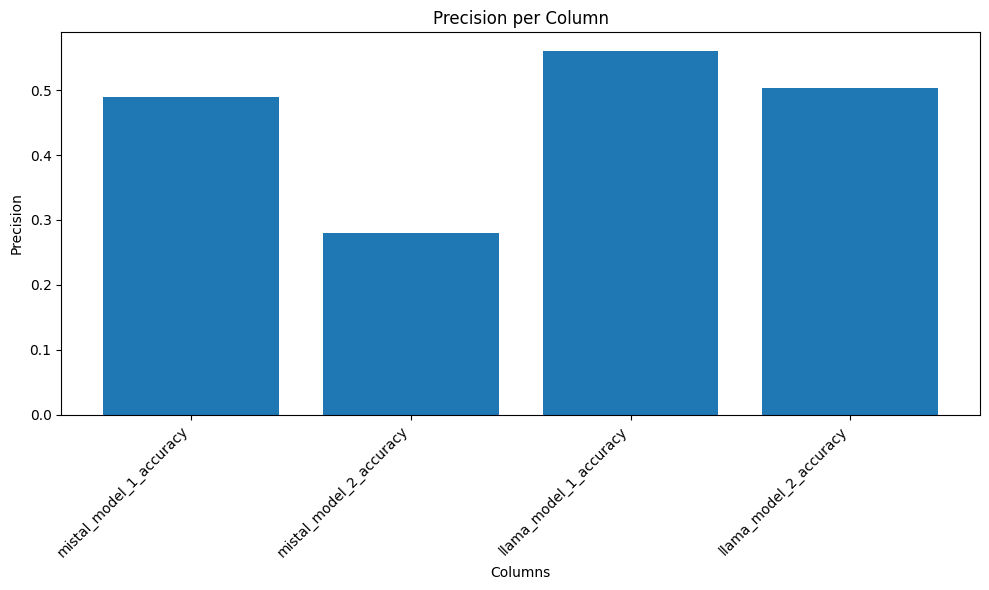

In [34]:
plot_from_dict(model_performance_dict)